# Refer https://www.analyticsindiamag.com/implementing-bayesian-optimization-on-xgboost-a-beginners-guide/

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from KUtils.eda import chartil

from xgboost.sklearn import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, recall_score, precision_score

In [3]:
adult_income_df = pd.read_csv('cleaned.csv')

In [4]:
# encode categorical variables using Label Encoder
# select all categorical variables
df_categorical = adult_income_df.select_dtypes(include=['object'])
df_categorical.head()

# apply Label encoder to df_categorical
le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)
df_categorical.head()

# concat df_categorical with original df
adult_income_df = adult_income_df.drop(df_categorical.columns, axis=1)
adult_income_df = pd.concat([adult_income_df, df_categorical], axis=1)
adult_income_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country,target
0,39,11.258240,13,2174,0,40,5,9,4,0,1,4,1,0,0
1,50,11.330336,13,0,0,13,4,9,2,3,0,4,1,0,0
2,38,12.281393,9,0,0,40,2,11,0,5,1,4,1,0,0
3,53,12.366153,7,0,0,40,2,1,2,5,0,2,1,0,0
4,28,12.732011,13,0,0,40,2,9,2,9,5,2,0,1,0
5,37,12.558777,14,0,0,40,2,12,2,3,5,4,0,0,0
6,49,11.984097,5,0,0,16,2,6,3,7,1,2,0,1,0
7,52,12.253157,9,0,0,45,4,11,2,3,0,4,1,0,1
8,31,10.731624,14,14084,0,50,2,12,4,9,1,4,0,0,1
9,42,11.979479,13,5178,0,40,2,9,2,3,0,4,1,0,1


In [5]:
from sklearn.preprocessing import StandardScaler
numerical_column_names = ['age','fnlwgt','education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = StandardScaler()

adult_income_df[numerical_column_names] = scaler.fit_transform(adult_income_df[numerical_column_names])

C:\Users\keshav\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\keshav\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
# convert target variable income to categorical
adult_income_df['target'] = adult_income_df['target'].astype('category')

X = adult_income_df.drop('target', axis=1)
y = adult_income_df['target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=43)

In [7]:
 from bayes_opt import BayesianOptimization

In [8]:
 import xgboost as xgb

In [9]:
dtrain = xgb.DMatrix(X_train, label=y_train)

C:\Users\keshav\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [21]:
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
        'gamma': gamma,
        'n_estimators': int(n_estimators),
        'learning_rate':learning_rate,
        'subsample': 0.8,
        'eta': 0.1,
        'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (5, 9),
    'gamma': (0, 1),
    'learning_rate':(0.5, 0.9),
    'n_estimators':(200,500)
})

In [22]:
 xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.3341   |  0.5963   |  0.7801   |  7.467    |  205.6    |
|  2        | -0.3244   |  0.5558   |  0.5424   |  7.019    |  208.2    |
|  3        | -0.3237   |  0.7682   |  0.722    |  7.855    |  380.4    |
|  4        | -0.3398   |  0.5181   |  0.8441   |  6.612    |  250.4    |
|  5        | -0.3214   |  0.5756   |  0.512    |  7.935    |  282.4    |
|  6        | -0.333    |  0.8191   |  0.8949   |  7.79     |  211.2    |
|  7        | -0.3557   |  0.2567   |  0.6915   |  8.822    |  440.7    |
|  8        | -0.3149   |  0.9513   |  0.615    |  6.937    |  287.2    |
|  9        | -0.3191   |  4.289e-1 |  0.5      |  5.0      |  500.0    |
|  10       | -0.3191   |  0.0      |  0.5      |  5.0      |  331.7    |
|  11       | -0.3194   |  0.331    |  0.528    |  5.01     |  296.0    |
|  12       | -0.3155   |  0.941    | 

In [25]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

{'gamma': 0.908542802004139, 'learning_rate': 0.5074027424508007, 'max_depth': 5.076518071303925, 'n_estimators': 217.16229720023134}


In [26]:
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

In [27]:
print(params)

{'gamma': 0.908542802004139, 'learning_rate': 0.5074027424508007, 'max_depth': 5, 'n_estimators': 217}


# Final model

In [29]:
#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
final_clf = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
y_pred_default = final_clf.predict(X_test)

In [30]:
# Printing classification report
print(classification_report(y_test, y_pred_default))

local_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_default )

# Printing confusion matrix and accuracy
print('Confusion Matrix:')
print(local_confusion_matrix)

# Accuracy, precision, recall and f1 score
print('\nScores:')
accuracy = metrics.accuracy_score(y_test, y_pred_default)
precision = metrics.precision_score(y_test, y_pred_default)
recall = metrics.recall_score(y_test, y_pred_default)
f1_score = metrics.f1_score(y_test, y_pred_default)
roc_auc = metrics.roc_auc_score(y_test, y_pred_default)
sensitivity = recall
specificity =  local_confusion_matrix[0,0]/(local_confusion_matrix[0,0]+local_confusion_matrix[0,1])
print(" Accuracy {0:.3f}, \n Sensitivity {1:.3f}, \n Specificity {2:.3f}, \n Precision {3:.3f}, \n Recall {4:.3f}, \n f1_score {5:.3f}, \n roc_auc {6:.3f}".format(
    accuracy, sensitivity,specificity, precision,recall,f1_score,roc_auc))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      6972
           1       0.76      0.67      0.71      2244

   micro avg       0.87      0.87      0.87      9216
   macro avg       0.83      0.80      0.81      9216
weighted avg       0.86      0.87      0.86      9216

Confusion Matrix:
[[6487  485]
 [ 742 1502]]

Scores:
 Accuracy 0.867, 
 Sensitivity 0.669, 
 Specificity 0.930, 
 Precision 0.756, 
 Recall 0.669, 
 f1_score 0.710, 
 roc_auc 0.800


[0.03483829 0.0132012  0.14267915 0.12793683 0.06174999 0.0261904
 0.01835746 0.012716   0.08328697 0.03045967 0.3816645  0.01497343
 0.03562996 0.01631612]


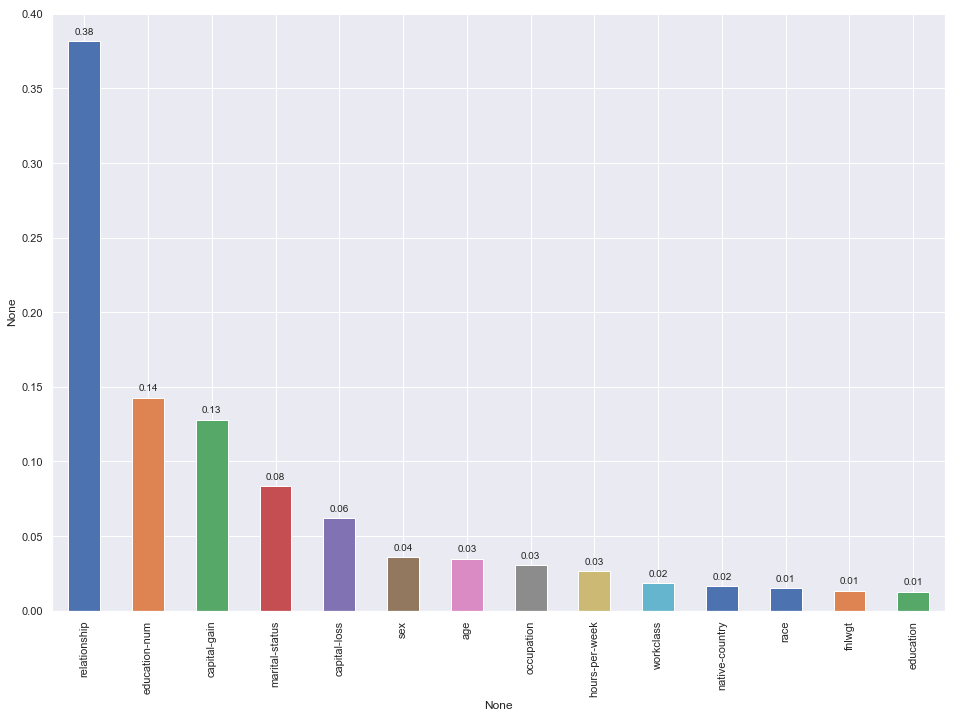

In [31]:
# Feature importance
importances = final_clf.feature_importances_
print(importances)

unique_dict = dict(zip(X_train.columns, importances))

chartil.core_barchart_from_series(
    pd.Series(unique_dict), 
    optional_settings={'sort_by_value':True, 'decimal_precision':2}) 